## POS Tagging, HMMs, Viterbi

Let's learn how to do POS tagging by Viterbi Heuristic using tagged Treebank corpus. Before going through the code, let's first understand the pseudo-code for the same. 

1. Tagged Treebank corpus is available (Sample data to training and test data set)
   - Basic text and structure exploration
2. Creating HMM model on the tagged data set.
   - Calculating Emission Probabaility: P(observation|state)
   - Calculating Transition Probability: P(state2|state1)
3. Developing algorithm for Viterbi Heuristic
4. Checking accuracy on the test data set


## 1. Exploring Treebank Tagged Corpus

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents())

In [3]:
# first few tagged sentences
print(wsj[:40])

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], [('Rudolph', 'NNP'), ('Agnew', 'NNP'), (',', ','), ('55', 'CD'), ('years', 'NNS'), ('old', 'JJ'), ('and', 'CC'), ('former', 'JJ'), ('chairman', 'NN'), ('of', 'IN'), ('Consolidated', 'NNP'), ('Gold', 'NNP'), ('Fields', 'NNP'), ('PLC', 'NNP'), (',', ','), ('was', 'VBD'), ('named', 'VBN'), ('*-1', '-NONE-'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('of', 'IN'), ('this', 'DT'), ('British', 'JJ'), ('industrial', 'JJ'), ('conglomerate', 'NN'), ('.', '.')], [('A', 'DT'), ('f

In [4]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(wsj,test_size=0.3)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

2739
1175
[[('Primerica', 'NNP'), ('closed', 'VBD'), ('at', 'IN'), ('$', '$'), ('28.25', 'CD'), ('*U*', '-NONE-'), (',', ','), ('down', 'RB'), ('50', 'CD'), ('cents', 'NNS'), ('.', '.')], [('The', 'DT'), ('recent', 'JJ'), ('quarter', 'NN'), ('includes', 'VBZ'), ('pretax', 'NN'), ('gains', 'NNS'), ('of', 'IN'), ('$', '$'), ('98', 'CD'), ('million', 'CD'), ('*U*', '-NONE-'), ('from', 'IN'), ('asset', 'NN'), ('sales', 'NNS'), (',', ','), ('while', 'IN'), ('like', 'JJ'), ('gains', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('year-earlier', 'JJ'), ('quarter', 'NN'), ('totaled', 'VBD'), ('$', '$'), ('61', 'CD'), ('million', 'CD'), ('*U*', '-NONE-'), ('.', '.')], [('But', 'CC'), ('rather', 'RB'), ('than', 'IN'), ('*', '-NONE-'), ('sell', 'VB'), ('new', 'JJ'), ('30-year', 'JJ'), ('bonds', 'NNS'), (',', ','), ('the', 'DT'), ('Treasury', 'NNP'), ('will', 'MD'), ('issue', 'VB'), ('$', '$'), ('10', 'CD'), ('billion', 'CD'), ('*U*', '-NONE-'), ('of', 'IN'), ('29year', 'JJ'), (',', ','), ('nine-month', 'J

In [5]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

70503

In [6]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Primerica', 'closed', 'at', '$', '28.25', '*U*', ',', 'down', '50', 'cents']

In [7]:
# vocabulary
V = set(tokens)
print(len(V))

10236


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

46

In [9]:
print(T)

{'JJ', 'NNP', 'CD', 'JJS', 'FW', 'MD', '-RRB-', 'VBP', 'NNPS', 'VBZ', 'WDT', 'PRP$', 'VBG', 'NNS', 'VBN', '-LRB-', 'SYM', '``', '$', '#', '-NONE-', 'RB', 'POS', 'RBS', 'WP$', 'UH', "''", 'PDT', 'IN', ':', 'TO', 'WP', ',', '.', 'EX', 'VBD', 'JJR', 'RBR', 'VB', 'CC', 'PRP', 'LS', 'NN', 'DT', 'WRB', 'RP'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [25]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'JJ'))
print(word_given_tag('large', 'VB'))
print(word_given_tag('large', 'NN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'MD'))
print(word_given_tag('will', 'NN'))
print(word_given_tag('will', 'VB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NN'))
print(word_given_tag('book', 'VB'))


 large
(20, 4056)
(0, 1809)
(0, 9240) 


 will
(210, 681)
(0, 9240)
(0, 1809)

 book
(4, 9240)
(0, 1809)


### Transition Probabilities

In [26]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [27]:
# examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(139, 4056)
(1840, 4056)
(2696, 5707)
(65, 1809)
(1035, 6687)
(2, 1155)
(6, 6687)


In [15]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))


(597, 2712)
(11, 2712)
(111, 2712)
(507, 2712)


In [30]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [31]:
tags_matrix

array([[  6.04043379e-02,   3.42702158e-02,   2.24358980e-02, ...,
          4.19132132e-03,   9.86193307e-04,   0.00000000e+00],
       [  9.27172136e-03,   3.81785542e-01,   1.94407050e-02, ...,
          2.84133386e-03,   1.49543892e-04,   1.49543892e-04],
       [  3.01348139e-02,   1.50674069e-02,   1.84377477e-01, ...,
          1.18953211e-03,   3.96510703e-04,   0.00000000e+00],
       ..., 
       [  2.07114071e-01,   1.25109509e-01,   2.48817243e-02, ...,
          1.40178727e-03,   0.00000000e+00,   0.00000000e+00],
       [  1.21739127e-01,   7.82608688e-02,   1.73913036e-02, ...,
          2.69565225e-01,   0.00000000e+00,   8.69565178e-03],
       [  4.16666679e-02,   2.77777780e-02,   1.38888890e-02, ...,
          2.01388896e-01,   0.00000000e+00,   0.00000000e+00]], dtype=float32)

In [32]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [33]:
tags_df

,JJ,NNP,CD,JJS,FW,MD,-RRB-,VBP,NNPS,VBZ,...,JJR,RBR,VB,CC,PRP,LS,NN,DT,WRB,RP
JJ,0.060404,0.034270,0.022436,0.000493,0.000000,0.000000,0.000247,0.000493,0.000986,0.000986,...,0.000740,0.000247,0.000000,0.014793,0.000247,0.000000,0.453649,0.004191,0.000986,0.000000
NNP,0.009272,0.381786,0.019441,0.000000,0.000000,0.010917,0.003739,0.003739,0.017945,0.036489,...,0.000150,0.000000,0.000748,0.038582,0.000598,0.000000,0.053686,0.002841,0.000150,0.000150
CD,0.030135,0.015067,0.184377,0.000793,0.000000,0.001983,0.000793,0.002379,0.000000,0.001586,...,0.001190,0.000397,0.000000,0.013878,0.000397,0.000000,0.199445,0.001190,0.000397,0.000000
JJS,0.147287,0.015504,0.038760,0.000000,0.000000,0.000000,0.000000,0.007752,0.007752,0.007752,...,0.000000,0.000000,0.000000,0.007752,0.000000,0.000000,0.333333,0.007752,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.001468,0.001468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001468,0.825257,0.000000,0.000000,0.000000,0.000000,0.002937,0.000000,0.000000
-RRB-,0.021053,0.021053,0.000000,0.000000,0.000000,0.021053,0.000000,0.010526,0.000000,0.021053,...,0.000000,0.000000,0.000000,0.031579,0.010526,0.000000,0.031579,0.073684,0.000000,0.000000
VBP,0.074157,0.014607,0.004494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001124,...,0.005618,0.004494,0.001124,0.003371,0.023596,0.000000,0.025843,0.106742,0.002247,0.012360
NNPS,0.000000,0.331461,0.000000,0.000000,0.000000,0.033708,0.000000,0.033708,0.000000,0.022472,...,0.000000,0.000000,0.000000,0.089888,0.000000,0.000000,0.016854,0.000000,0.005618,0.000000
VBZ,0.063165,0.019282,0.014628,0.000665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000665,...,0.007314,0.003324,0.002660,0.003324,0.012633,0.000000,0.039894,0.146277,0.003989,0.008644


In [34]:
tags_df.loc['.', :]

JJ        0.033555
NNP       0.186947
CD        0.008481
JJS       0.001844
FW        0.000000
MD        0.000000
-RRB-     0.004056
VBP       0.000000
NNPS      0.002581
VBZ       0.001475
WDT       0.000737
PRP$      0.005162
VBG       0.004056
NNS       0.045723
VBN       0.001106
-LRB-     0.003319
SYM       0.000000
``        0.066003
$         0.001106
#         0.000000
-NONE-    0.022861
RB        0.046091
POS       0.000000
RBS       0.000369
WP$       0.000000
UH        0.000000
''        0.057153
PDT       0.001106
IN        0.118363
:         0.001844
TO        0.001475
WP        0.002212
,         0.000000
.         0.000000
EX        0.004056
VBD       0.000737
JJR       0.001106
RBR       0.000369
VB        0.000000
CC        0.050147
PRP       0.057522
LS        0.001844
NN        0.040929
DT        0.220133
WRB       0.005531
RP        0.000000
Name: ., dtype: float32

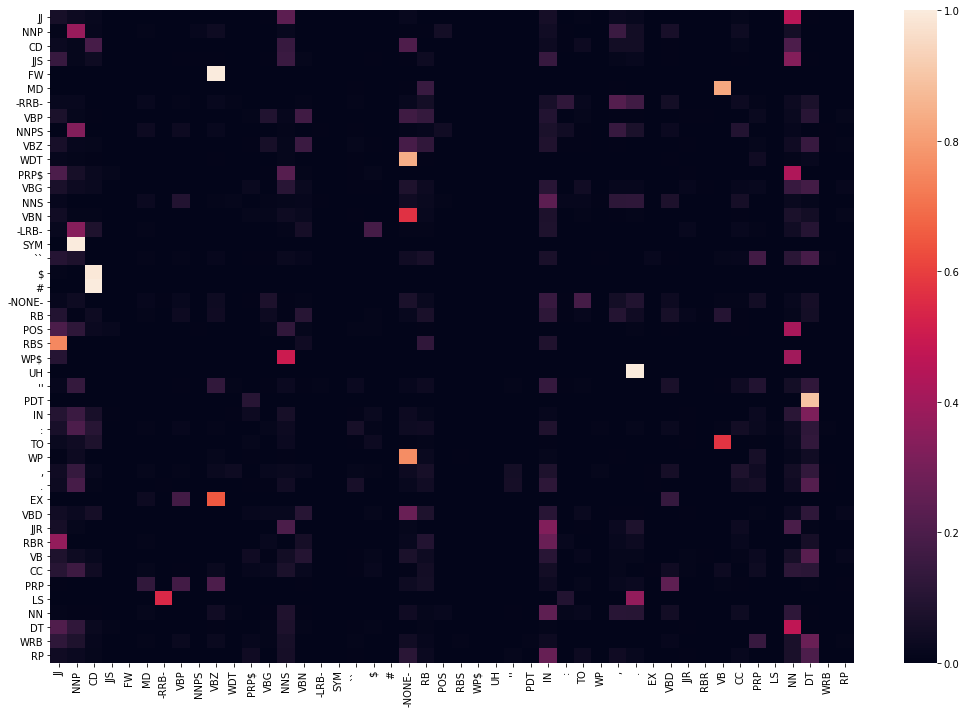

In [35]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


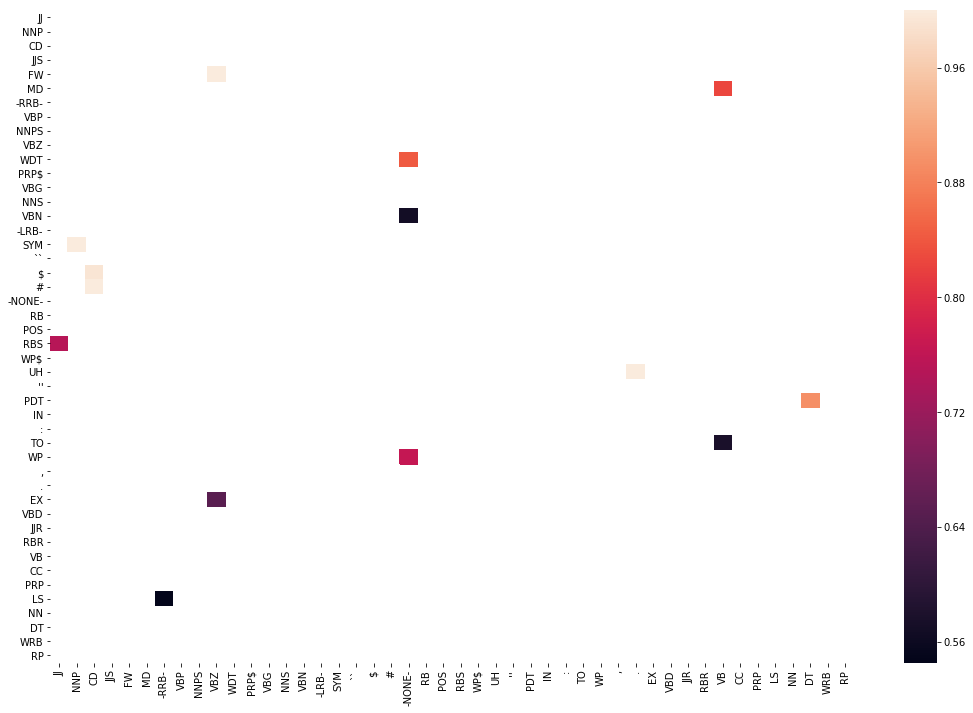

In [36]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [37]:
len(train_tagged_words)

70503

In [39]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



## 4. Evaluating on Test Set

In [43]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Individuals', 'NNS'),
  ('familiar', 'JJ'),
  ('with', 'IN'),
  ('the', 'DT'),
  ('Justice', 'NNP'),
  ('Department', 'NNP'),
  ("'s", 'POS'),
  ('policy', 'NN'),
  ('said', 'VBD'),
  ('that', 'IN'),
  ('Justice', 'JJ'),
  ('officials', 'NNS'),
  ('had', 'VBD'),
  ("n't", 'RB'),
  ('any', 'DT'),
  ('knowledge', 'NN'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('IRS', 'NNP'),
  ("'s", 'POS'),
  ('actions', 'NNS'),
  ('in', 'IN'),
  ('the', 'DT'),
  ('last', 'JJ'),
  ('week', 'NN'),
  ('.', '.')],
 [('In', 'IN'),
  ('her', 'PRP$'),
  ('wake', 'NN'),
  ('she', 'PRP'),
  ('left', 'VBD'),
  ('the', 'DT'),
  ('bitterness', 'NN'),
  ('and', 'CC'),
  ('anger', 'NN'),
  ('of', 'IN'),
  ('a', 'DT'),
  ('principal', 'NN'),
  ('who', 'WP'),
  ('*T*-81', '-NONE-'),
  ('was', 'VBD'),
  ('her', 'PRP$'),
  ('friend', 'NN'),
  ('and', 'CC'),
  ('now', 'RB'),
  ('calls', 'VBZ'),
  ('her', 'PRP'),
  ('a', 'DT'),
  ('betrayer', 'NN'),
  (';', ':'),
  ('of', 'IN'),
  ('colleagues', 'NNS'),
  ('who', 'WP'),
  

In [61]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [62]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  122.65850806236267
[('Individuals', 'JJ'), ('familiar', 'JJ'), ('with', 'IN'), ('the', 'DT'), ('Justice', 'NNP'), ('Department', 'NNP'), ("'s", 'POS'), ('policy', 'NN'), ('said', 'VBD'), ('that', 'IN'), ('Justice', 'NNP'), ('officials', 'NNS'), ('had', 'VBD'), ("n't", 'RB'), ('any', 'DT'), ('knowledge', 'NN'), ('of', 'IN'), ('the', 'DT'), ('IRS', 'NNP'), ("'s", 'POS'), ('actions', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('last', 'JJ'), ('week', 'NN'), ('.', '.'), ('In', 'IN'), ('her', 'PRP$'), ('wake', 'NN'), ('she', 'PRP'), ('left', 'VBD'), ('the', 'DT'), ('bitterness', 'JJ'), ('and', 'CC'), ('anger', 'JJ'), ('of', 'IN'), ('a', 'DT'), ('principal', 'NN'), ('who', 'WP'), ('*T*-81', 'JJ'), ('was', 'VBD'), ('her', 'PRP$'), ('friend', 'JJ'), ('and', 'CC'), ('now', 'RB'), ('calls', 'VBZ'), ('her', 'PRP$'), ('a', 'JJ'), ('betrayer', 'JJ'), (';', ':'), ('of', 'IN'), ('colleagues', 'NNS'), ('who', 'WP'), ('*T*-82', 'JJ'), ('say', 'VBP'), ('0', '-NONE-'), ('she', 'PRP'), (

In [64]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [65]:
accuracy = len(check)/len(tagged_seq)

In [66]:
accuracy

0.8736263736263736

In [67]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [68]:
incorrect_tagged_cases

[[('.', '.'), (('Individuals', 'JJ'), ('Individuals', 'NNS'))],
 [('that', 'IN'), (('Justice', 'NNP'), ('Justice', 'JJ'))],
 [('the', 'DT'), (('bitterness', 'JJ'), ('bitterness', 'NN'))],
 [('and', 'CC'), (('anger', 'JJ'), ('anger', 'NN'))],
 [('who', 'WP'), (('*T*-81', 'JJ'), ('*T*-81', '-NONE-'))],
 [('her', 'PRP$'), (('friend', 'JJ'), ('friend', 'NN'))],
 [('calls', 'VBZ'), (('her', 'PRP$'), ('her', 'PRP'))],
 [('her', 'PRP'), (('a', 'JJ'), ('a', 'DT'))],
 [('a', 'DT'), (('betrayer', 'JJ'), ('betrayer', 'NN'))],
 [('who', 'WP'), (('*T*-82', 'JJ'), ('*T*-82', '-NONE-'))],
 [('who', 'WP'), (('*T*-83', 'JJ'), ('*T*-83', '-NONE-'))],
 [('*T*-83', '-NONE-'), (('defended', 'JJ'), ('defended', 'VBD'))],
 [('was', 'VBD'), (('treated', 'JJ'), ('treated', 'VBN'))],
 [('of', 'IN'), (('school-district', 'JJ'), ('school-district', 'NN'))],
 [('local', 'JJ'), (('martyr', 'JJ'), ('martyr', 'NN'))],
 [('under', 'IN'), (('cultivation', 'JJ'), ('cultivation', 'NN'))],
 [(',', ','), (('soybeans', 'JJ'

In [69]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [70]:
print(tagged_seq)
print(difference)

[('Twitter', 'JJ'), ('is', 'VBZ'), ('the', 'DT'), ('best', 'JJS'), ('networking', 'NN'), ('social', 'JJ'), ('site', 'JJ'), ('.', '.'), ('Man', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('social', 'JJ'), ('animal', 'JJ'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('is', 'VBZ'), ('an', 'DT'), ('emerging', 'VBG'), ('field', 'NN'), ('.', '.'), ('Data', 'NNP'), ('science', 'NN'), ('jobs', 'NNS'), ('are', 'VBP'), ('high', 'JJ'), ('in', 'IN'), ('demand', 'NN'), ('.', '.')]
19.30107307434082
